In [1]:
import os
os.environ["OMP_NUM_THREADS"] = "1"


In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
sns.set_theme(style="whitegrid", font_scale=1.2)
plt.rcParams['font.family'] = 'sans-serif' 
plt.rcParams['axes.unicode_minus'] = False 

In [4]:
df = pd.read_csv("traindata.csv")
geno_means = df.groupby('GenotypingValue')['CL/F'].mean().sort_values()
print("基因型各组清除率均值 (用于确认标签方向):")
print(geno_means)
geno_map = {
    geno_means.index[0]: 'PM/IM (Slow)',   # 清除率最低
    geno_means.index[1]: 'EM (Normal)',    # 清除率居中
    geno_means.index[2]: 'UM (Rapid)'      # 清除率最高
}
df['Genotype_Label'] = df['GenotypingValue'].map(geno_map)
crp_cutoff = 10  #以CRP=10mg/L为临界值
df['Inflammation_Status'] = df['CRP'].apply(lambda x: 'High CRP' if x > crp_cutoff else 'Low CRP')
print(f"\n以 CRP = {crp_cutoff} mg/L 为界限进行分组统计:")
print(df['Inflammation_Status'].value_counts())



基因型各组清除率均值 (用于确认标签方向):
GenotypingValue
3    2.729610
2    3.112340
1    3.827402
Name: CL/F, dtype: float64

以 CRP = 10 mg/L 为界限进行分组统计:
Inflammation_Status
High CRP    404
Low CRP     142
Name: count, dtype: int64


C:\Users\86178\AppData\Local\Temp\ipykernel_11640\2389082340.py:13: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.violinplot(x='Genotype_Label', y='CL/F', data=df, palette='viridis', order=['PM/IM (Slow)', 'EM (Normal)', 'UM (Rapid)'], ax=axes[1])


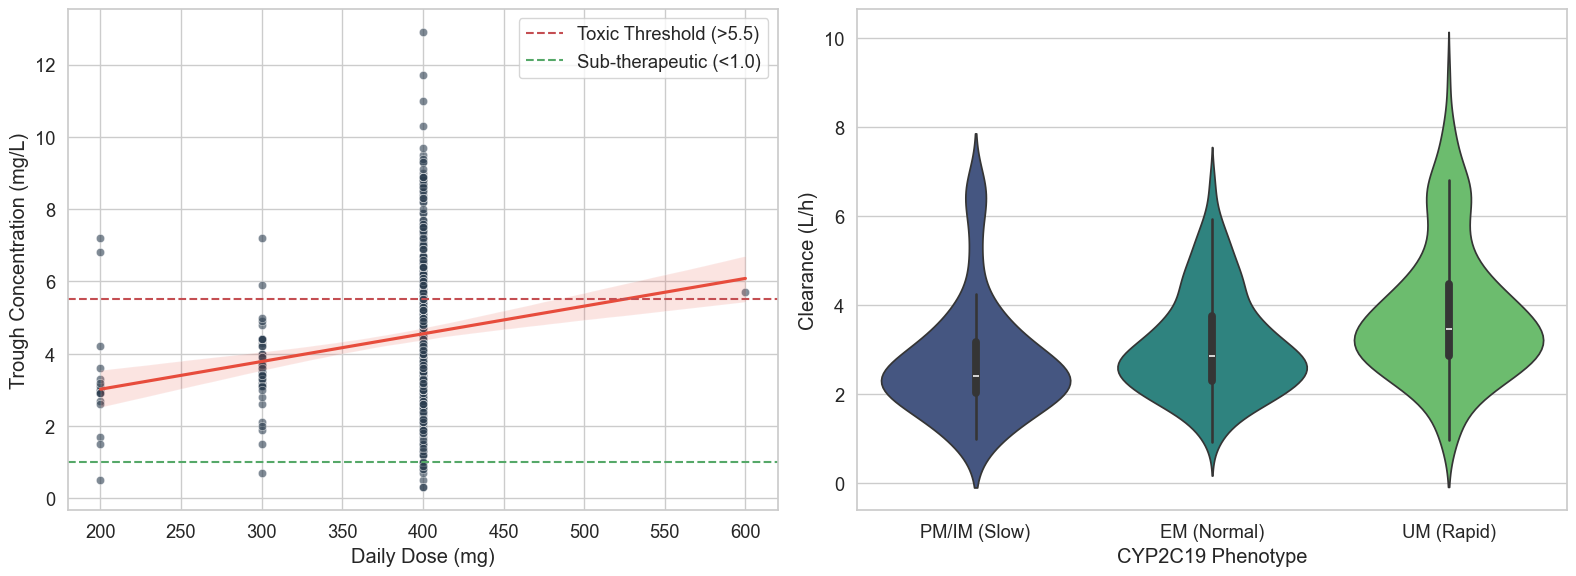

In [5]:
fig1, axes = plt.subplots(1, 2, figsize=(16, 6))#创建1行2列的子图布局，图形尺寸为16×6英寸
#👈散点图：显示每日剂量(Daydose)与血药浓度(DV)的关系  回归线：红色线条显示总体趋势  透明度0.6避免点重叠
sns.scatterplot(x='Daydose', y='DV', data=df, alpha=0.6, color='#2c3e50', ax=axes[0])
sns.regplot(x='Daydose', y='DV', data=df, scatter=False, color='#e74c3c', ax=axes[0])
#axes[0].set_title('High Inter-individual Variability\n(Dose vs Concentration)', fontweight='bold')
axes[0].set_xlabel('Daily Dose (mg)')
axes[0].set_ylabel('Trough Concentration (mg/L)')
#红色虚线：毒性阈值(5.5 mg/L)，高于此值可能中毒   绿色虚线：无效阈值(1.0 mg/L)，低于此值治疗效果不足
axes[0].axhline(5.5, color='r', linestyle='--', label='Toxic Threshold (>5.5)')
axes[0].axhline(1.0, color='g', linestyle='--', label='Sub-therapeutic (<1.0)')
axes[0].legend()
#👉小提琴图：显示不同基因型组的清除率分布 排序：按代谢速度从慢到快排列   CL/F：表观清除率，值越高表示药物代谢越快
sns.violinplot(x='Genotype_Label', y='CL/F', data=df, palette='viridis', order=['PM/IM (Slow)', 'EM (Normal)', 'UM (Rapid)'], ax=axes[1])
#axes[1].set_title('Clearance Distribution by Genotype', fontweight='bold')
axes[1].set_xlabel('CYP2C19 Phenotype')
axes[1].set_ylabel('Clearance (L/h)')

plt.tight_layout()
plt.show()


C:\Users\86178\AppData\Local\Temp\ipykernel_11640\3729209844.py:10: FutureWarning: 

Setting a gradient palette using color= is deprecated and will be removed in v0.14.0. Set `palette='dark:black'` for the same effect.

  sns.stripplot(x='Genotype_Label', y='CL/F', hue='Inflammation_Status',


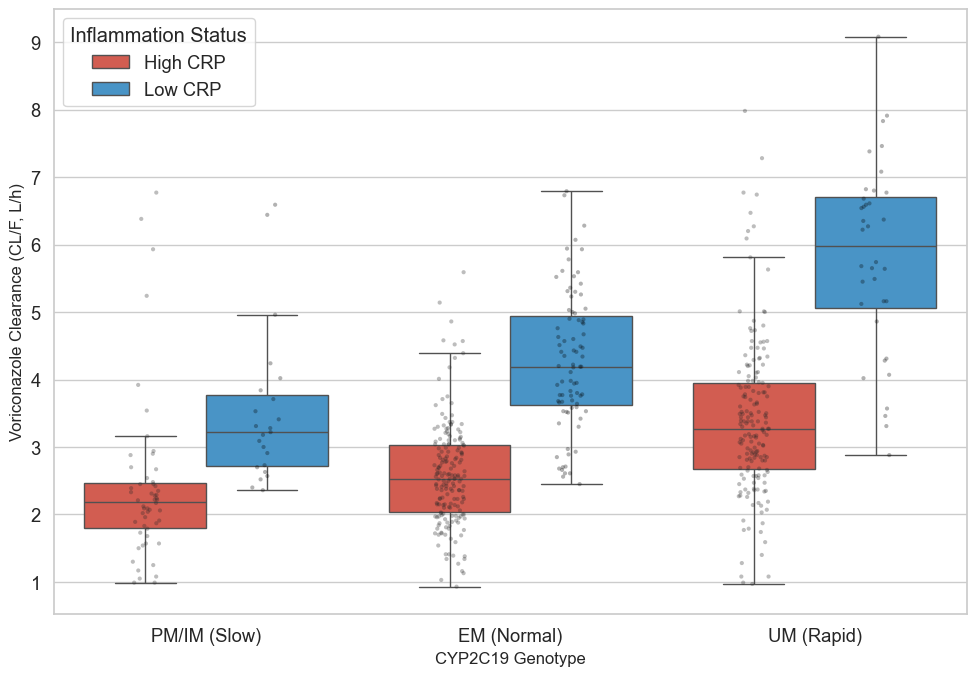

In [6]:
#创建了一个箱线图结合散点图，用于展示炎症状态对基因型效应的调节作用（即表型转换现象）
plt.figure(figsize=(10, 7))
colors = {"Low CRP": "#3498db", "High CRP": "#e74c3c"}
#箱线图x轴：基因型（从慢到快代谢）  y轴：伏立康唑清除率(CL/F)  hue参数：按炎症状态分组着色  showfliers=False：不显示异常值点
sns.boxplot(x='Genotype_Label', y='CL/F', hue='Inflammation_Status', 
            data=df, palette=colors, 
            order=['PM/IM (Slow)', 'EM (Normal)', 'UM (Rapid)'],
            showfliers=False) 
#dodge=True：使不同组的点分开显示  黑色半透明点：显示原始数据分布  
sns.stripplot(x='Genotype_Label', y='CL/F', hue='Inflammation_Status', 
              data=df, dodge=True, color='black', alpha=0.3, size=3,
              order=['PM/IM (Slow)', 'EM (Normal)', 'UM (Rapid)'])

#plt.title('Evidence of Inflammation-Driven Phenoconversion\n(Genotype Effect Diminishes under High Inflammation)', fontsize=14, fontweight='bold')
plt.xlabel('CYP2C19 Genotype', fontsize=12)
plt.ylabel('Voriconazole Clearance (CL/F, L/h)', fontsize=12)
#只保留前两个图例项（避免重复） 图例标题为"Inflammation Status"  位置在左上角
handles, labels = plt.gca().get_legend_handles_labels()
plt.legend(handles[0:2], labels[0:2], title='Inflammation Status', loc='upper left')

plt.tight_layout()
plt.show()


In [7]:
#通过统计检验来验证炎症状态对基因型效应的调节作用
print("\n=== 统计验证 (Statistical Validation) ===")
#分别对"低炎症"和"高炎症"两组进行分析   sub_df包含当前炎症状态下的所有数据
for status in ['Low CRP', 'High CRP']:
    sub_df = df[df['Inflammation_Status'] == status]
    #按基因型分组提取清除率数据
    groups = [sub_df[sub_df['Genotype_Label'] == g]['CL/F'] for g in ['PM/IM (Slow)', 'EM (Normal)', 'UM (Rapid)']]
    #使用Kruskal-Wallis检验---非参数方差分析，判断三个基因型组的清除率是否有显著差异
    stat, p_val = stats.kruskal(*groups)
    print(f"[{status}] Genotype Effect P-value: {p_val:.4e}")
    if p_val < 0.05:
        print(f"  -> 结论: 在 {status} 状态下，基因型显著影响清除率。")
    else:
        print(f"  -> 结论: 在 {status} 状态下，基因型的影响不再显著 (Phenoconversion!)。")


=== 统计验证 (Statistical Validation) ===
[Low CRP] Genotype Effect P-value: 7.5930e-10
  -> 结论: 在 Low CRP 状态下，基因型显著影响清除率。
[High CRP] Genotype Effect P-value: 3.2131e-18
  -> 结论: 在 High CRP 状态下，基因型显著影响清除率。


从图像与统计结果来看，左图显示出巨大的个体差异，明确指出固定剂量策略不可行，必须走向个体化给药；右图则呈现出 Slow < Normal < Rapid 的稳定阶梯趋势，证明基因型在总体人群中具有清晰的剂量预测价值。统计结果也进一步强化了这一点：Low CRP 组的基因型效应十分显著，而 High CRP 组即使处于炎症状态仍然保持显著，这提示“炎症完全掩盖基因效应”的强假设并不成立。造成这一结果的核心原因在于样本结构：CRP > 10 的临床炎症标准在 ICU 数据中覆盖了绝大多数个体，把轻度与重度炎症混在一起，从而稀释了真正的“基因表型失效”现象。因此，为构建更有说服力的机制模型，我们需要基于数据分布而非临床阈值来重新定义炎症强度，例如采用 CRP 三分位数，将最高 33% 的重炎组与最低 33% 的轻炎组对照，以寻找基因型预测失效的真正“崩溃点”。接下来，使用 Boruta 进行特征筛选，以数学方式验证 CRP 与基因型作为核心决定因素的地位，从而为高质量论文提供机制与数据的双重支持。

缺失值处理前样本量 n = 546
缺失值处理后样本量 n = 546
因缺失值被排除 n = 0
最终纳入建模的样本量 n = 546

Candidate features included for selection (29):
['Daydose', 'GCs_Methylprednisolone', 'GCs_Dexamethasone', 'GCs_Prednisone', 'GCs_Hydrocortisone', 'PPI_Omeprazole', 'PPI_Rabeprazole', 'PPI_Pantoprazole', 'PPI_Lansoprazole', 'PPI_Esomeprazole', 'PPI_IlaprazoleSodium', 'Sex', 'Age', 'Weight', 'Hb', 'PLT', 'ALT', 'GGT', 'ALP', 'TP', 'ALB', 'GLB', 'TBIL', 'BUN', 'Cr', 'UA', 'CRP', 'Hemodialysis', 'GenotypingValue']

>>> Running Boruta ...


C:\Users\86178\AppData\Local\Temp\ipykernel_11640\16747340.py:24: FutureWarning: Downcasting behavior in Series and DataFrame methods 'where', 'mask', and 'clip' is deprecated. In a future version this will not infer object dtypes or cast all-round floats to integers. Instead call result.infer_objects(copy=False) for object inference, or cast round floats explicitly. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df[col] = df[col].clip(lower=lower, upper=upper)


Selected by Boruta (12):
['Sex', 'Age', 'Weight', 'ALT', 'TP', 'ALB', 'TBIL', 'BUN', 'Cr', 'UA', 'CRP', 'GenotypingValue']

>>> Running LASSO ...
Selected by LASSO (12):
['PPI_IlaprazoleSodium', 'Sex', 'Age', 'Weight', 'Hb', 'PLT', 'GGT', 'ALB', 'TBIL', 'CRP', 'Hemodialysis', 'GenotypingValue']

>>> Calculating VIF ...

===== VIF results (all variables) =====
                   Feature        VIF
19                      TP  38.658733
20                     ALB  22.902436
21                     GLB  17.878886
23                     BUN   2.450512
18                     ALP   2.306875
17                     GGT   2.172382
24                      Cr   2.066763
22                    TBIL   1.674906
25                      UA   1.503480
12                     Age   1.499120
27            Hemodialysis   1.478114
15                     PLT   1.461494
11                     Sex   1.417091
16                     ALT   1.403542
26                     CRP   1.361093
13                  Weight   1

c:\python_vscode\PPCs-web\.venv\lib\site-packages\statsmodels\regression\linear_model.py:1782: RuntimeWarning: divide by zero encountered in scalar divide
  return 1 - self.ssr/self.centered_tss
C:\Users\86178\AppData\Local\Temp\ipykernel_11640\16747340.py:93: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=plot1, x='Importance', y='Feature', palette=colors.to_list())


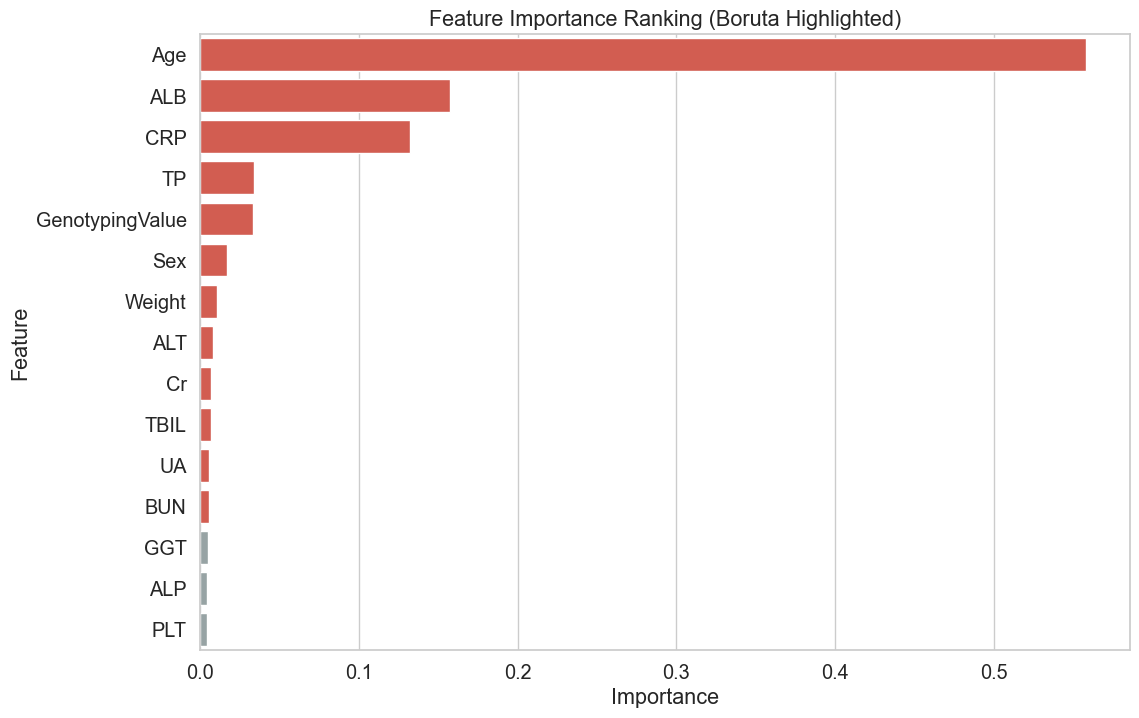


>>> Generating Figure 2: LASSO ...


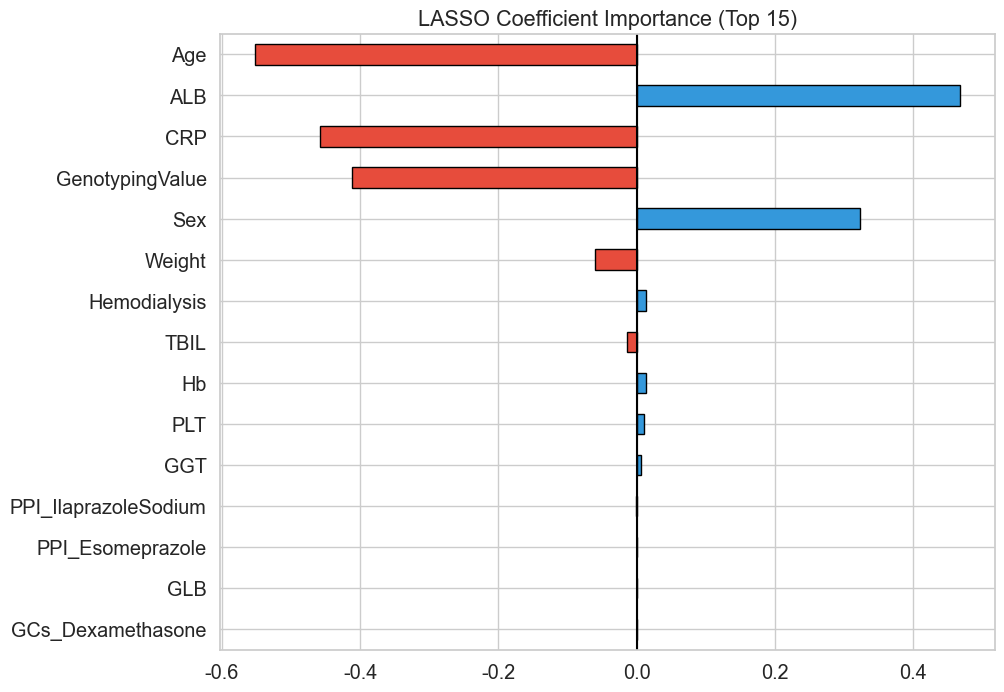


>>> Generating Figure 3: VIF ...


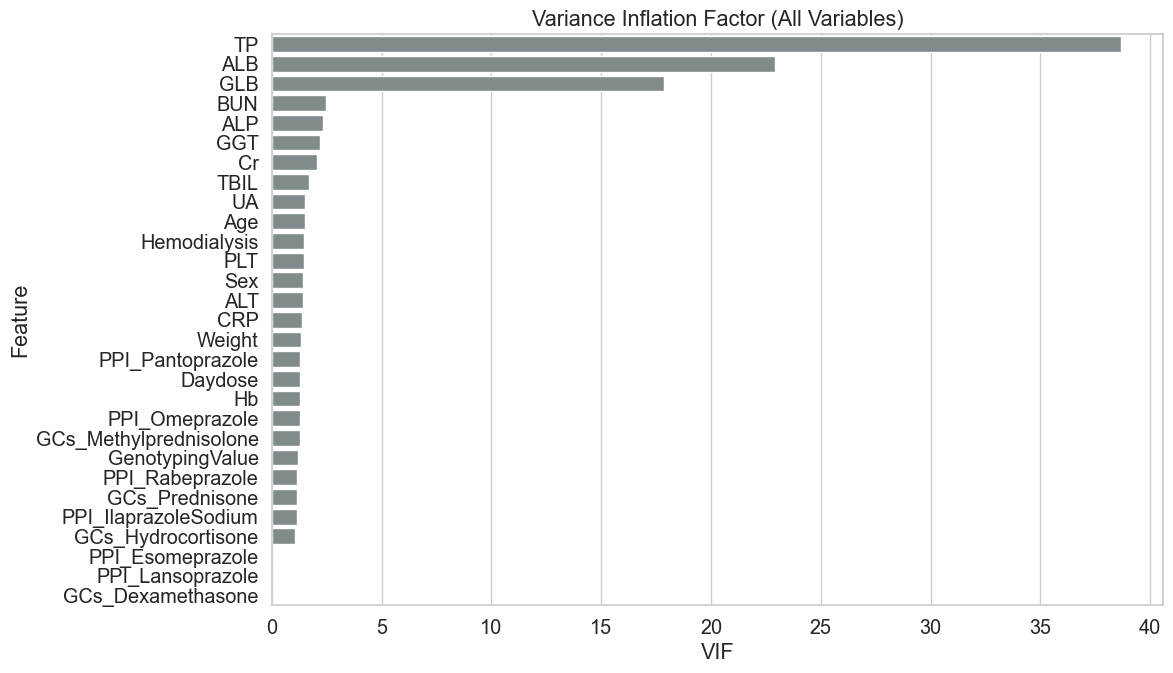


Final Golden Features (7):
['CRP', 'Sex', 'ALB', 'Age', 'Weight', 'GenotypingValue', 'TBIL']



In [9]:
#双重特征筛选
!pip install Boruta
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LassoCV
from boruta import BorutaPy
from statsmodels.stats.outliers_influence import variance_inflation_factor
import statsmodels.api as sm
sns.set_theme(style="whitegrid", font_scale=1.3)
plt.rcParams['font.sans-serif'] = ['Arial', 'SimHei']
plt.rcParams['axes.unicode_minus'] = False

df = pd.read_csv("traindata.csv")
# 数值型变量的离群值处理（1%-99%缩尾）
numeric_cols = df.select_dtypes(include=[np.number]).columns.tolist()
for col in numeric_cols:
    if col not in ['GenotypingValue']:
        lower = df[col].quantile(0.01)
        upper = df[col].quantile(0.99)
        df[col] = df[col].clip(lower=lower, upper=upper)
# 排除不相关的变量
exclude = ['TIME','CL/F','V','DV', 'Genotype_Label',
           'Inflammation_Status', 'CRP_Group', 'CRP_Tertile','Predicted_Conc']
# 排除高度共线性的变量
drop_collinear = ['AST', 'DBIL', 'IBIL', 'Totaldosage']

features = [
    c for c in df.columns #遍历DataFrame df的所有列名，每个列名临时赋值给变量 c
    if c not in exclude + drop_collinear #exclude + drop_collinear将两个列表合并为一个排除列表，检查列名 c是否不在这个合并后的排除列表中，排除那些明确指定不需要的列
    and pd.api.types.is_numeric_dtype(df[c]) #使用pandas的API检查列 df[c]的数据类型是否是数值型
]

target = 'CL/F'
X = df[features]
y = df[target].values

n_before = df.shape[0]
df_complete = df.dropna()
n_after = df_complete.shape[0]

print(f"缺失值处理前样本量 n = {n_before}")
print(f"缺失值处理后样本量 n = {n_after}")
print(f"因缺失值被排除 n = {n_before - n_after}")
df_model = df.dropna(subset=[target])
print(f"最终纳入建模的样本量 n = {df_model.shape[0]}")

print(f"\nCandidate features included for selection ({len(features)}):")
print(features)
#三种特征选择方法并行运行
#方法一：Boruta（基于随机森林）
print("\n>>> Running Boruta ...")
rf = RandomForestRegressor(n_jobs=-1, max_depth=5, random_state=42)
boruta_selector = BorutaPy(rf, n_estimators='auto', random_state=42, perc=90)
boruta_selector.fit(X.values, y)
boruta_features = list(X.columns[boruta_selector.support_])
print(f"Selected by Boruta ({len(boruta_features)}):")
print(boruta_features)
#方法二：LASSO（L1正则化回归）
print("\n>>> Running LASSO ...")
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)
lasso = LassoCV(cv=5, random_state=42, max_iter=10000).fit(X_scaled, y)
lasso_coefs = pd.Series(lasso.coef_, index=features)
lasso_features = lasso_coefs[lasso_coefs.abs() > 0].index.tolist()
print(f"Selected by LASSO ({len(lasso_features)}):")
print(lasso_features)
#方法三：VIF（方差膨胀因子）
print("\n>>> Calculating VIF ...")
X_vif = sm.add_constant(X)
vif_df = pd.DataFrame({
    "Feature": X.columns,
    "VIF": [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]
}).sort_values(by="VIF", ascending=False)
print("\n===== VIF results (all variables) =====")
print(vif_df)
#图1：随机森林特征重要性 + Boruta标记，显示前15个最重要特征，红色标记Boruta选中的特征 
print("\n>>> Generating Figure 1: Random Forest + Boruta ...")
rf.fit(X, y)
importances = rf.feature_importances_
idx = np.argsort(importances)[::-1]
plot1 = pd.DataFrame({
    'Feature': np.array(features)[idx],
    'Importance': importances[idx],
    'Boruta': ['Yes' if f in boruta_features else 'No' for f in np.array(features)[idx]]
}).head(15)

plt.figure(figsize=(12, 8))
colors = plot1['Boruta'].map({'Yes': '#e74c3c', 'No': '#95a5a6'})
sns.barplot(data=plot1, x='Importance', y='Feature', palette=colors.to_list())
plt.title('Feature Importance Ranking (Boruta Highlighted)')
plt.savefig('figure1_rf_boruta.png', dpi=1200)
plt.rcParams['font.family'] = 'Arial'
plt.show()
#图2：LASSO系数重要性，蓝色：正相关特征（增加清除率）红色：负相关特征（降低清除率
print("\n>>> Generating Figure 2: LASSO ...")
top15 = lasso_coefs.abs().sort_values(ascending=False).head(15).index
top_coef = lasso_coefs[top15]
plt.figure(figsize=(10, 8))
colors = ['#3498db' if c > 0 else '#e74c3c' for c in top_coef.values]
top_coef.plot(kind='barh', color=colors, edgecolor='black')
plt.axvline(0, color='black')
plt.title('LASSO Coefficient Importance (Top 15)')
plt.gca().invert_yaxis()
plt.savefig('figure2_lasso_importance.png', dpi=1200)
plt.rcParams['font.family'] = 'Arial'
plt.show()
#图3：VIF方差膨胀因子  识别存在多重共线性的变量
print("\n>>> Generating Figure 3: VIF ...")
plt.figure(figsize=(12, 7))
sns.barplot(data=vif_df, x='VIF', y='Feature', color='#7f8c8d')
plt.title('Variance Inflation Factor (All Variables)')
plt.tight_layout()
plt.savefig('figure3_vif.png', dpi=1200)
plt.rcParams['font.family'] = 'Arial'
plt.show()
# Final Golden Features  取Boruta和LASSO的交集作为最终特征
final_features = list(set(boruta_features) & set(lasso_features))
if not final_features:
    final_features = boruta_features
print("\n============================================")
print(f"Final Golden Features ({len(final_features)}):")
print(final_features)
print("============================================\n")

In [41]:
# 选择特定的七个特征
selected_features =['CRP', 'ALB', 'GenotypingValue', 'Age', 'Weight', 'TBIL','Sex']
X_selected = X[selected_features]

# 计算这些特征的VIF值
print("\n>>> Calculating VIF for selected features ...")
X_selected = sm.add_constant(X_selected)  # 添加常数列
vif_df = pd.DataFrame({
    "Feature": X_selected.columns,
    "VIF": [variance_inflation_factor(X_selected.values, i) for i in range(X_selected.shape[1])]
}).sort_values(by="VIF", ascending=False)

# 输出结果
print("\n===== VIF results (selected variables) =====")
print(vif_df)



>>> Calculating VIF for selected features ...

===== VIF results (selected variables) =====
           Feature         VIF
0            const  126.218440
2              ALB    1.404054
4              Age    1.256117
7              Sex    1.240439
5           Weight    1.212236
6             TBIL    1.160362
1              CRP    1.131327
3  GenotypingValue    1.045773


In [10]:
#shap图分析
train_data =pd.read_csv(r"traindata.csv",encoding='utf-8')
print(train_data.shape) #获取目前的形状
print(train_data.columns)
trainy=train_data['CL/F']
trainy.head()
trainx=train_data.drop('CL/F',axis=1)
trainx.head()

#训练集数据标准化，建议用StandardScaler标准化连续变量
from sklearn.preprocessing import StandardScaler  
import numpy as np 
scaler = StandardScaler()
continuous_columns = ['Weight','Age','ALB','TBIL','CRP']  #连续变量
columns_to_copy = ['GenotypingValue','Sex']  #分类变量

scaled_continuous_train = scaler.fit_transform(train_data[continuous_columns]) # 只选择连续变量列进行fit_transform 
scaled_data_train = pd.DataFrame(scaled_continuous_train, columns=continuous_columns)  
scaled_data_train[columns_to_copy] = train_data[columns_to_copy]
scaled_data_train['CL/F'] = train_data['CL/F']

trainy=scaled_data_train['CL/F']
trainy.head()
trainx=scaled_data_train.drop('CL/F',axis=1)
trainx.head()
y_train = trainy.copy()
x_train = trainx


(546, 37)
Index(['TIME', 'DV', 'Daydose', 'Totaldosage', 'GCs_Methylprednisolone',
       'GCs_Dexamethasone', 'GCs_Prednisone', 'GCs_Hydrocortisone',
       'PPI_Omeprazole', 'PPI_Rabeprazole', 'PPI_Pantoprazole',
       'PPI_Lansoprazole', 'PPI_Esomeprazole', 'PPI_IlaprazoleSodium', 'Sex',
       'Age', 'Weight', 'Hb', 'PLT', 'ALT', 'AST', 'GGT', 'ALP', 'TP', 'ALB',
       'GLB', 'TBIL', 'DBIL', 'IBIL', 'BUN', 'Cr', 'UA', 'CRP', 'Hemodialysis',
       'GenotypingValue', 'CL/F', 'V'],
      dtype='object')


ExactExplainer explainer: 547it [01:09,  7.10it/s]                         


(546, 7) (546,)


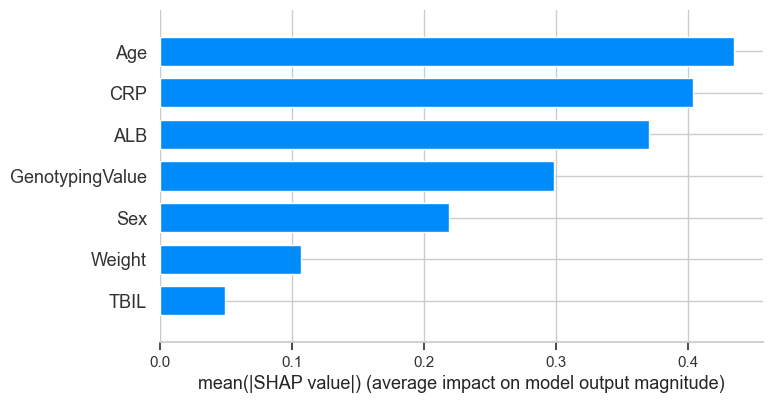

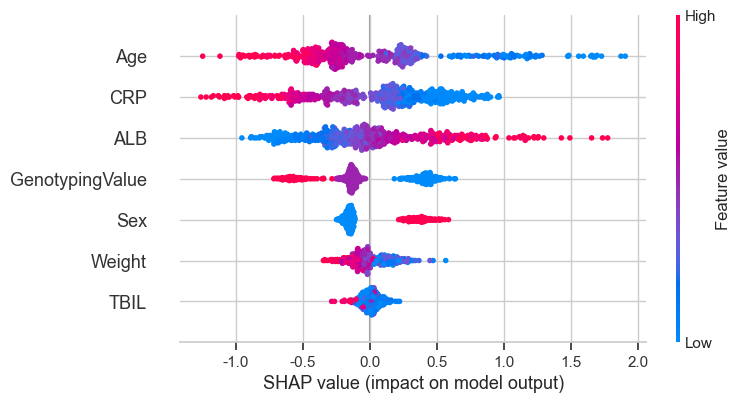

In [13]:
import shap
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor
# 选择特定的七个特征
selected_features = ['Age', 'Sex', 'Weight', 'GenotypingValue', 'ALB', 'TBIL', 'CRP']
X_selected = x_train[selected_features]

# 假设 X_selected 是训练数据集特征，y_train 是连续值标签
model = XGBRegressor(n_estimators=1200,learning_rate=0.03,max_depth=5,min_child_weight=5,gamma=0.05,subsample=0.8, base_score=0.5,  
                        colsample_bytree=0.9,reg_alpha=0.1,reg_lambda=1.0,objective="reg:squarederror")
model.fit(X_selected, y_train)  # 使用回归模型进行训练
# 假设 x_train 是你的训练数据，y_train 是你的标签

# SHAP 计算
explainer = shap.Explainer(model.predict, X_selected)

shap_values = explainer(X_selected)

print(X_selected.shape, y_train.shape)

# 绘制 SHAP 条形图（特征重要性）
plt.rcParams['font.family'] = 'Arial'

shap.summary_plot(
    shap_values.values,
    X_selected,
    plot_type="bar",
    show=False)

plt.savefig("SHAP_feature_importance_bar.png", dpi=1200, bbox_inches="tight")
plt.show()


# 绘制 SHAP 蜂群图
plt.rcParams['font.family'] = 'Arial'

shap.summary_plot(
    shap_values.values,
    X_selected,
    plot_type="dot",
    show=False
)

plt.savefig("SHAP_beeswarm_plot.png", dpi=1200, bbox_inches="tight")
plt.show()



C:\Users\86178\AppData\Local\Temp\ipykernel_11640\1511846612.py:25: FutureWarning: Downcasting behavior in Series and DataFrame methods 'where', 'mask', and 'clip' is deprecated. In a future version this will not infer object dtypes or cast all-round floats to integers. Instead call result.infer_objects(copy=False) for object inference, or cast round floats explicitly. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df[col] = df[col].clip(lower=lower, upper=upper)


Full Model Feature Count: 29
Compact Model Feature Count: 7
[Full] Train R²=0.994, MAE=0.080, MSE=0.011,RMSE=0.103 | Test R²=0.901, MAE=0.288,MSE=0.011, RMSE=0.416
[Compact] Train R²=0.989, MAE=0.110, MSE=0.020,RMSE=0.143 | Test R²=0.916, MAE=0.283,MSE=0.020, RMSE=0.385


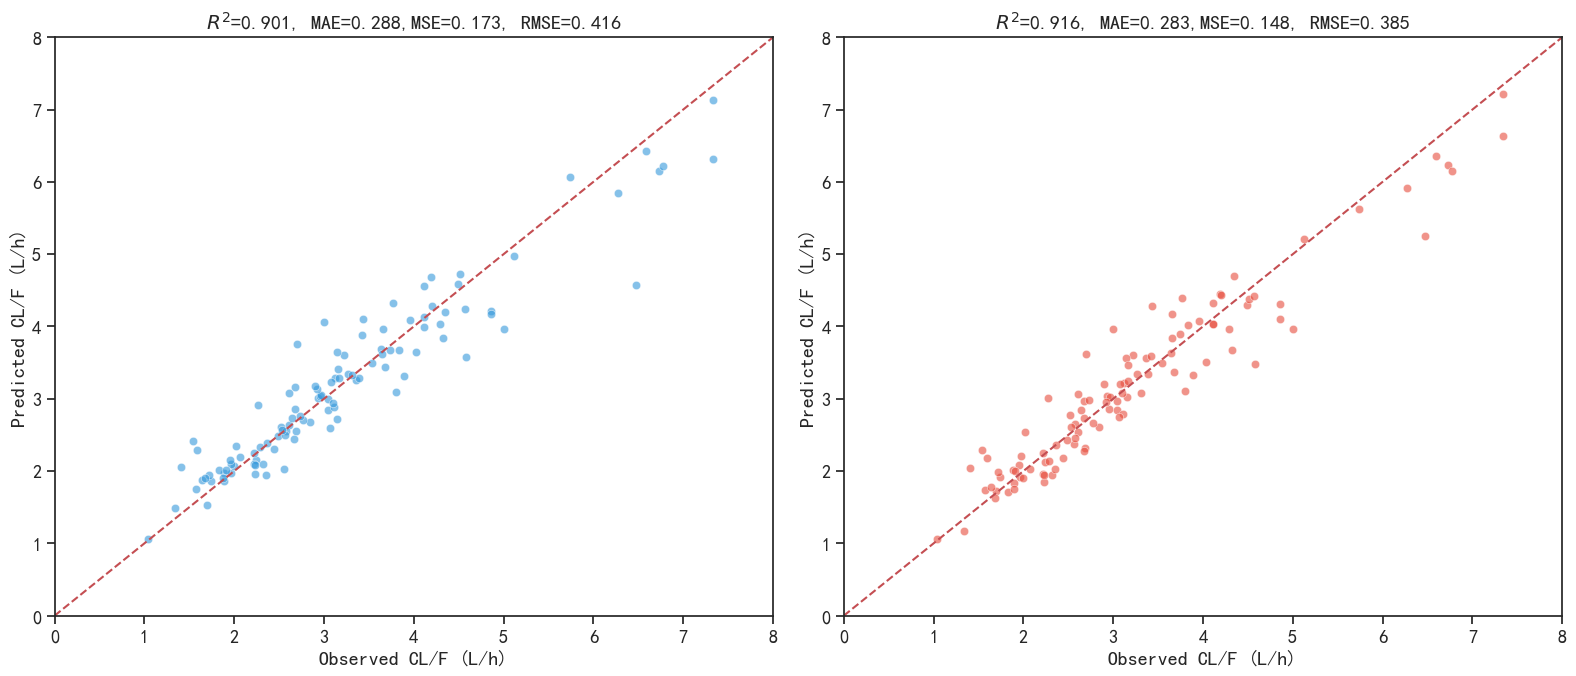


🏆 Performance Comparison:
1. Full Model (29 features):   R2 = 0.9012 | MSE = 0.1732 | RMSE = 0.4161
2. Compact Model (7 features): R2 = 0.9156 | MSE = 0.1479 | RMSE = 0.3845
--------------------------------------------------
✅ Conclusion: The Compact Model achieves performance comparable to the Full Model.
   This indicates that only 7 core clinical variables are sufficient for accurate prediction,
   greatly enhancing clinical applicability and simplifying data requirements.


In [22]:
#验证精简模型的鲁棒性
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error
from xgboost import XGBRegressor
from sklearn.ensemble import RandomForestRegressor
from lightgbm import LGBMRegressor
sns.set_theme(style="ticks", font_scale=1.2)
plt.rcParams['font.sans-serif'] = ['SimHei', 'Arial Unicode MS']
plt.rcParams['axes.unicode_minus'] = False

df = pd.read_csv("traindata.csv")

target = 'CL/F'

numeric_cols = df.select_dtypes(include=[np.number]).columns.tolist()
#对连续型数值变量进行离群值处理（1%-99%缩尾），只对连续变量（唯一值>10）处理，避免分类变量被错误处理
for col in numeric_cols:
    if col != 'GenotypingValue' and df[col].nunique() > 10:
        lower = df[col].quantile(0.01)
        upper = df[col].quantile(0.99)
        df[col] = df[col].clip(lower=lower, upper=upper)
# 完整模型：29个临床特征
features_full = [
    'Daydose', 'GCs_Methylprednisolone', 'GCs_Dexamethasone', 'GCs_Prednisone', 'GCs_Hydrocortisone', 'PPI_Omeprazole', 
    'PPI_Rabeprazole', 'PPI_Pantoprazole', 'PPI_Lansoprazole','PPI_Esomeprazole', 'PPI_IlaprazoleSodium', 'Hemodialysis',
    'Sex','Age', 'Weight', 'Hb', 'PLT', 'ALT', 'GGT', 'ALP', 'TP',
    'ALB', 'GLB', 'TBIL', 'BUN', 'Cr', 'UA', 'CRP',  'GenotypingValue'
]
# 精简模型：7个核心特征
features_compact = ['GenotypingValue', 'Sex', 'ALB', 'Weight', 'Age', 'CRP', 'TBIL']

print(f"Full Model Feature Count: {len(features_full)}")
print(f"Compact Model Feature Count: {len(features_compact)}")
#使用XGBoost算法
train_idx, test_idx = train_test_split(df.index, test_size=0.2, random_state=42)
def train_and_eval(features, name):
    X_train = df.loc[train_idx, features]
    y_train = df.loc[train_idx, target]
    X_test  = df.loc[test_idx, features]
    y_test  = df.loc[test_idx, target]

    model = XGBRegressor(n_estimators=1200,learning_rate=0.03,max_depth=5,min_child_weight=5,gamma=0.05,subsample=0.8,
                        colsample_bytree=0.9,reg_alpha=0.1,reg_lambda=1.0)
    #model.fit( X_train, y_train, eval_set=(X_test, y_test), early_stopping_rounds=200, use_best_model=True )

    model.fit(X_train, y_train)

    # ===== 训练集预测 =====
    y_train_pred = model.predict(X_train)
    r2_train  = r2_score(y_train, y_train_pred)
    mae_train = mean_absolute_error(y_train, y_train_pred)
    mse_train = mean_squared_error(y_train, y_train_pred)
    rmse_train = np.sqrt(mse_train)

    # ===== 测试集预测 =====
    y_test_pred = model.predict(X_test)
    r2_test  = r2_score(y_test, y_test_pred)
    mae_test = mean_absolute_error(y_test, y_test_pred)
    mse_test = mean_squared_error(y_test, y_test_pred)
    rmse_test = np.sqrt(mse_test)

    print(
        f"[{name}] "
        f"Train R²={r2_train:.3f}, MAE={mae_train:.3f}, MSE={mse_train:.3f},RMSE={rmse_train:.3f} | "
        f"Test R²={r2_test:.3f}, MAE={mae_test:.3f},MSE={mse_train:.3f}, RMSE={rmse_test:.3f}"
    )

    return (
        y_test,
        y_test_pred,
        r2_train, mae_train, mse_train, rmse_train,
        r2_test,  mae_test,  mse_test,  rmse_test
    )


(
    y_test,
    pred_full,
    r2_train_full, mae_train_full, mse_train_full, rmse_train_full,
    r2_full,       mae_full,       mse_full,       rmse_full
) = train_and_eval(features_full, "Full")

(
    _,
    pred_compact,
    r2_train_compact, mae_train_compact, mse_train_compact, rmse_train_compact,
    r2_compact,       mae_compact,       mse_compact,       rmse_compact
) = train_and_eval(features_compact, "Compact")

fig, axes = plt.subplots(1, 2, figsize=(16, 7))

sns.scatterplot(x=y_test, y=pred_full, color='#3498db', alpha=0.6, ax=axes[0])
axes[0].plot([0, 8], [0, 8], 'r--')
axes[0].set_title(
     f'$R^2$={r2_full:.3f}, MAE={mae_full:.3f},MSE={mse_full:.3f}, RMSE={rmse_full:.3f}',
    fontweight='bold'
)
axes[0].set_xlabel('Observed CL/F (L/h)')
axes[0].set_ylabel('Predicted CL/F (L/h)')
axes[0].set_xlim(0, 8)
axes[0].set_ylim(0, 8)

sns.scatterplot(x=y_test, y=pred_compact, color='#e74c3c', alpha=0.6, ax=axes[1])
axes[1].plot([0, 8], [0, 8], 'r--')
axes[1].set_title(
    f'$R^2$={r2_compact:.3f}, MAE={mae_compact:.3f},MSE={mse_compact:.3f}, RMSE={rmse_compact:.3f}',
    fontweight='bold'
)
axes[1].set_xlabel('Observed CL/F (L/h)')
axes[1].set_ylabel('Predicted CL/F (L/h)')
axes[1].set_xlim(0, 8)
axes[1].set_ylim(0, 8)
plt.rcParams['font.family'] = 'Arial'
plt.tight_layout()
plt.savefig('model_comparison_result.png', dpi=1200)
plt.show()

print("\n" + "="*50)
print("🏆 Performance Comparison:")
print(f"1. Full Model (29 features):   R2 = {r2_full:.4f} | MSE = {mse_full:.4f} | RMSE = {rmse_full:.4f}")
print(f"2. Compact Model (7 features): R2 = {r2_compact:.4f} | MSE = {mse_compact:.4f} | RMSE = {rmse_compact:.4f}")
print("-" * 50)

if r2_compact >= r2_full * 0.95:
    print("✅ Conclusion: The Compact Model achieves performance comparable to the Full Model.")
    print("   This indicates that only 7 core clinical variables are sufficient for accurate prediction,")
    print("   greatly enhancing clinical applicability and simplifying data requirements.")
else:
    print("ℹ️ Conclusion: The Full Model performs slightly better, but the Compact Model still maintains strong predictive ability.")

print("="*50)
#左图：完整模型预测效果  蓝色散点，29个特征  红色虚线为理想预测线（y=x）
#右图：精简模型预测效果  红色散点，仅7个特征  比较两个模型的R²和MAE值


In [494]:
ppk+cl+c

LGBMRegressor(num_leaves=296,n_estimators=207,learning_rate=0.082,max_bin=78,bagging_fraction=0.936,reg_lambda= 0.15,reg_alpha= 0.57,
                     max_depth= 4,colsample_bytree= 0.36,objective='regression_l2',metric='l2',subsample=0.32,random_state=42,bagging_freq=6)

RandomForestRegressor(
    n_estimators=500,
    random_state=42,

    max_depth=4,              
    min_samples_split=6,      
    min_samples_leaf=3,      

    max_features=0.7,        
    max_samples=0.8,          

    bootstrap=True,
    n_jobs=-1
)
XGBRegressor(n_estimators=1200,learning_rate=0.03,max_depth=5,min_child_weight=5,gamma=0.05,subsample=0.8,
                        colsample_bytree=0.9,reg_alpha=0.1,reg_lambda=1.0)
CatBoostRegressor(
    loss_function="RMSE",
    iterations=5000,
    learning_rate=0.03,
    depth=5,
    l2_leaf_reg=30,
    min_data_in_leaf=80,
    rsm=0.6,
    bootstrap_type="Bernoulli",
    subsample=0.6,
    random_seed=42,
    verbose=False
)
model.fit( X, y, eval_set=(X_test, y_test), early_stopping_rounds=200, use_best_model=True )

NameError: name 'ppk' is not defined

C:\Users\86178\AppData\Local\Temp\ipykernel_11640\545978941.py:32: FutureWarning: Downcasting behavior in Series and DataFrame methods 'where', 'mask', and 'clip' is deprecated. In a future version this will not infer object dtypes or cast all-round floats to integers. Instead call result.infer_objects(copy=False) for object inference, or cast round floats explicitly. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df[col] = df[col].clip(lower=lower, upper=upper)


Full Model Feature Count: 29
Compact Model Feature Count: 8
>>> 正在训练 CL/F 预测模型...

>>> 正在执行浓度反推与校准 (Concentration Calibration)...
 [Calibrator] Non-linear Coefs: [ 0.80529025 -0.02498023], Intercept: 0.8659
 [Calibrator] Non-linear Coefs: [ 0.88323546 -0.03111358], Intercept: 0.6671

✅ [Compact Model] 浓度预测性能 (谷浓度样本): R²=0.7433,MAE=0.3475, MSE=0.2716, RMSE=0.5212 mg/L


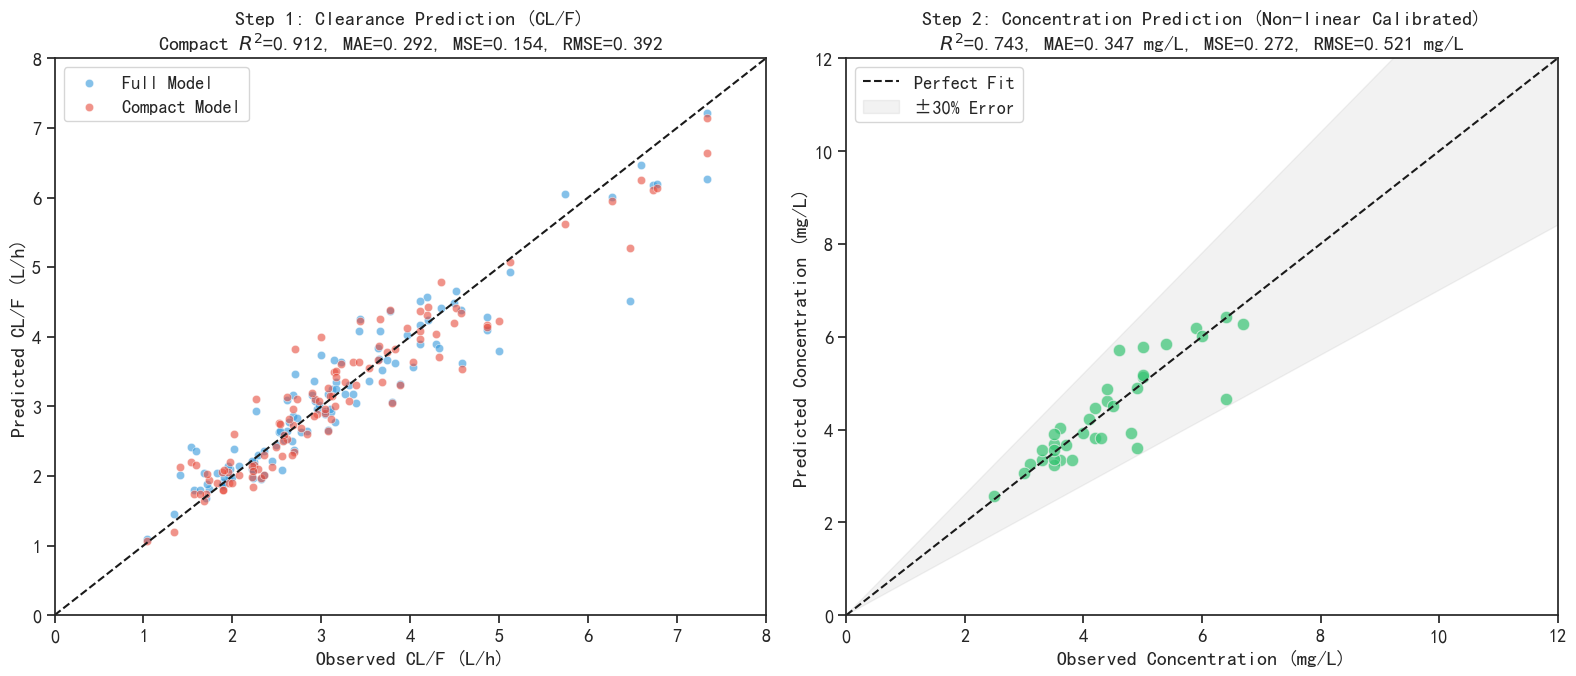


>>> 正在导出预测结果...
✅ 已成功导出至: hybrid_model_final_predictions.csv
     Patient_ID  Daydose  Time_Since_Dose  Observed_CL  Predicted_CL_Compact  \
316         316      400              4.2         1.54              2.194838   
77           77      400              4.0         3.54              3.553847   
360         360      400              6.9         3.77              4.384284   
90           90      400              6.0         2.44              2.133518   
495         495      400             10.7         1.89              1.798076   

     Observed_Conc  Predicted_Conc_Compact  Error_Conc  Is_Trough_Sample  
316            7.1                5.579922   -1.520078             False  
77             1.6                4.124941    2.524941             False  
360            3.4                3.575046    0.175046             False  
90             5.3                5.668077    0.368077             False  
495            5.9                6.180747    0.280747              True  
c:\pyth

In [29]:
#混合机器学习-药代动力学模型，用于预测伏立康唑的血药浓度。结合了机器学习预测清除率和药代动力学公式反推浓度的方法
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error
from xgboost import XGBRegressor
from catboost import CatBoostRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression 
from sklearn.preprocessing import PolynomialFeatures # 引入多项式特征
from sklearn.pipeline import make_pipeline # 引入管道

sns.set_theme(style="ticks", font_scale=1.2)
plt.rcParams['font.sans-serif'] = ['SimHei', 'Arial Unicode MS']
plt.rcParams['axes.unicode_minus'] = False

# ==========================================
# 1. 数据准备
# ==========================================
df = pd.read_csv("traindata.csv")

target = 'CL/F'

# 极值处理 (Winsorization)
numeric_cols = df.select_dtypes(include=[np.number]).columns.tolist()
for col in numeric_cols:
    if col != 'GenotypingValue' and df[col].nunique() > 10:
        lower = df[col].quantile(0.01)
        upper = df[col].quantile(0.99)
        df[col] = df[col].clip(lower=lower, upper=upper)

# 定义特征集
features_full = [
    'Daydose', 'GCs_Methylprednisolone', 'GCs_Dexamethasone', 
    'GCs_Prednisone', 'GCs_Hydrocortisone', 'PPI_Omeprazole', 
    'PPI_Rabeprazole', 'PPI_Pantoprazole', 'PPI_Lansoprazole',
    'PPI_Esomeprazole', 'PPI_IlaprazoleSodium', 'Sex',
    'Age', 'Weight', 'Hb', 'PLT', 'ALT', 'GGT', 'ALP', 'TP',
    'ALB', 'GLB', 'TBIL', 'BUN', 'Cr', 'UA', 'CRP', 'Hemodialysis', 'GenotypingValue' # 确保包含 Daydose
]

# ⚠️ 关键修正：Compact模型必须包含 'Daydose' 以捕捉剂量饱和效应
features_compact = ['GenotypingValue', 'Weight', 'Sex', 'CRP', 'ALB', 'Age', 'Daydose','TBIL']

print(f"Full Model Feature Count: {len(features_full)}")
print(f"Compact Model Feature Count: {len(features_compact)}")

# 划分数据集
train_idx, test_idx = train_test_split(df.index, test_size=0.2, random_state=42)

# ==========================================
# 2. 训练清除率预测模型 (CL/F)
# ==========================================
def train_and_eval(features, name):
    X = df.loc[train_idx, features]
    y = df.loc[train_idx, target]
    X_test = df.loc[test_idx, features]
    y_test = df.loc[test_idx, target]

    model = XGBRegressor(n_estimators=1200,learning_rate=0.03,max_depth=5,min_child_weight=5,gamma=0.05,subsample=0.8,
                        colsample_bytree=0.9,reg_alpha=0.1,reg_lambda=1.0)
    #model.fit( X, y, eval_set=(X_test, y_test), early_stopping_rounds=200, use_best_model=True )
    model.fit(X, y)
    y_pred = model.predict(X_test)

    r2 = r2_score(y_test, y_pred)
    mae = mean_absolute_error(y_test, y_pred)
    mse = mean_squared_error(y_test, y_pred)
    rmse = np.sqrt(mean_squared_error(y_test, y_pred))

    # 修改：返回 model 对象以便后续反推浓度使用
    return y_test, y_pred, r2, mae, mse, rmse, model

print(">>> 正在训练 CL/F 预测模型...") #训练并评估了两个模型：一个使用完整特征集 (features_full)，一个使用精简特征集 (features_compact)
y_test_cl, pred_full_cl, r2_full, mae_full, mse_full, rmse_full, model_full = train_and_eval(features_full, "Full")
_, pred_compact_cl, r2_compact, mae_compact, mse_compact, rmse_compact, model_compact = train_and_eval(features_compact, "Compact")

# ==========================================
# 3. 浓度反推与校准模块 (Concentration Back-calculation)
# ==========================================
print("\n>>> 正在执行浓度反推与校准 (Concentration Calibration)...")
#基础药代动力学公式
def calculate_theoretical_conc(pred_cl, day_dose):
    """
    基础物理公式: Css_avg = DayDose / (24 * CL)
    """
    pred_cl_safe = np.maximum(pred_cl, 0.1) # 物理约束，防止除零
    return day_dose / (24 * pred_cl_safe)

def train_calibrator_and_predict(model, features, train_idx, test_idx):
    # --- Step A: 准备训练集数据 ---
    X_train = df.loc[train_idx, features]
    dose_train = df.loc[train_idx, 'Daydose']
    dv_train = df.loc[train_idx, 'DV']
    time_train = df.loc[train_idx, 'TIME']
    
    # 预测训练集 CL
    pred_cl_train = model.predict(X_train)
    
    # 计算训练集理论浓度
    theory_conc_train = calculate_theoretical_conc(pred_cl_train, dose_train)
    
    # --- Step B: 训练校准器 (仅使用谷浓度样本) ---校准器：它是一个用于对药代动力学模型的预测结果进行调整的模型。
    # 筛选 Time >= 7 的样本进行校准，确保关系稳定
    mask = time_train >= 7
    if mask.sum() > 10:  #如果时间 >= 7的样本数量足够多（大于10个），则选择这些样本进行校准
        X_cal = theory_conc_train[mask].values.reshape(-1, 1)
        y_cal = dv_train[mask].values
    else:                #如果 >= 7天的样本数量不足 10 个，则使用所有样本进行校准
        X_cal = theory_conc_train.values.reshape(-1, 1)
        y_cal = dv_train.values
    
    # 使用二次多项式回归捕捉浓度与理论浓度之间的非线性关系 (y = ax^2 + bx + c)
    calibrator = make_pipeline(PolynomialFeatures(degree=2, include_bias=False), LinearRegression())
    calibrator.fit(X_cal, y_cal)
    
    # 提取系数用于展示
    linear_model = calibrator.named_steps['linearregression']
    print(f" [Calibrator] Non-linear Coefs: {linear_model.coef_}, Intercept: {linear_model.intercept_:.4f}")
    
    # --- Step C: 应用到测试集 ---
    X_test = df.loc[test_idx, features]
    dose_test = df.loc[test_idx, 'Daydose']
    
    # 预测测试集 CL
    pred_cl_test = model.predict(X_test)
    
    # 计算测试集理论浓度
    theory_conc_test = calculate_theoretical_conc(pred_cl_test, dose_test)
    
    # 应用校准器修正
    pred_dv_final = calibrator.predict(theory_conc_test.values.reshape(-1, 1))
    pred_dv_final = np.maximum(pred_dv_final, 0.1) # 物理约束
    
    return pred_dv_final, calibrator

# 执行浓度预测
pred_dv_full, calibrator_full = train_calibrator_and_predict(model_full,features_full,train_idx,test_idx)
pred_dv_compact, calibrator_compact = train_calibrator_and_predict(model_compact,features_compact,train_idx,test_idx)
# ==========================================
# 4. 评估与可视化 (Evaluation)
# ==========================================
# 获取真实浓度用于评估
y_test_dv = df.loc[test_idx, 'DV']
test_time = df.loc[test_idx, 'TIME']

# 只在谷浓度样本上评估指标 (Time >= 7d)
eval_mask = test_time >= 7
r2_conc_compact = r2_score(y_test_dv[eval_mask], pred_dv_compact[eval_mask])
mae_conc_compact = mean_absolute_error(y_test_dv[eval_mask], pred_dv_compact[eval_mask])
mse_conc_compact = mean_squared_error(y_test_dv[eval_mask], pred_dv_compact[eval_mask])
rmse_conc_compact = np.sqrt(mean_squared_error(y_test_dv[eval_mask], pred_dv_compact[eval_mask]))

print(f"\n✅ [Compact Model] 浓度预测性能 (谷浓度样本): R²={r2_conc_compact:.4f},MAE={mae_conc_compact:.4f}, MSE={mse_conc_compact:.4f}, RMSE={rmse_conc_compact:.4f} mg/L")

# 可视化结果
fig, axes = plt.subplots(1, 2, figsize=(16, 7))

# Plot 1: CL/F 预测 (Full蓝色 vs Compact红色)
sns.scatterplot(x=y_test_cl, y=pred_full_cl, color='#3498db', alpha=0.6, ax=axes[0], label='Full Model')
sns.scatterplot(x=y_test_cl, y=pred_compact_cl, color='#e74c3c', alpha=0.6, ax=axes[0], label='Compact Model')
axes[0].plot([0, 8], [0, 8], 'k--')
axes[0].set_title(
    f'Step 1: Clearance Prediction (CL/F)\nCompact $R^2$={r2_compact:.3f}, MAE={mae_compact:.3f}, MSE={mse_compact:.3f}, RMSE={rmse_compact:.3f}',
    fontweight='bold'
)

axes[0].set_xlabel('Observed CL/F (L/h)')
axes[0].set_ylabel('Predicted CL/F (L/h)')
axes[0].set_xlim(0, 8)
axes[0].set_ylim(0, 8)
axes[0].legend()

# Plot 2: 浓度预测 (Compact Model Only)
sns.scatterplot(x=y_test_dv[eval_mask], y=pred_dv_compact[eval_mask], color='#2ecc71', alpha=0.7, s=80, ax=axes[1])
axes[1].plot([0, 12], [0, 12], 'k--', label='Perfect Fit')
# 绘制误差带
x_vals = np.linspace(0, 12, 100)
axes[1].fill_between(x_vals, x_vals*0.7, x_vals*1.3, color='gray', alpha=0.1, label='±30% Error')
axes[1].set_title(
    f'Step 2: Concentration Prediction (Non-linear Calibrated)\n$R^2$={r2_conc_compact:.3f}, MAE={mae_conc_compact:.3f} mg/L, MSE={mse_conc_compact:.3f}, RMSE={rmse_conc_compact:.3f} mg/L',
    fontweight='bold'
)

axes[1].set_xlabel('Observed Concentration (mg/L)')
axes[1].set_ylabel('Predicted Concentration (mg/L)')
axes[1].set_xlim(0, 12)
axes[1].set_ylim(0, 12)
axes[1].legend()

plt.tight_layout()
plt.rcParams['font.family'] = 'Arial'
plt.savefig('hybrid_model_performance.png', dpi=1200)
plt.show()

# ==========================================
# 5. 导出预测结果 (Output)
# ==========================================
print("\n>>> 正在导出预测结果...")
results_df = pd.DataFrame({
    'Patient_ID': test_idx, # 保留原始索引
    'Daydose': df.loc[test_idx, 'Daydose'],
    'Time_Since_Dose': test_time,
    'Observed_CL': y_test_cl,
    'Predicted_CL_Compact': pred_compact_cl,
    'Observed_Conc': y_test_dv,
    'Predicted_Conc_Compact': pred_dv_compact,
    'Error_Conc': pred_dv_compact - y_test_dv,
    'Is_Trough_Sample': eval_mask
})

output_filename = 'hybrid_model_final_predictions.csv'
results_df.to_csv(output_filename, index=False)
print(f"✅ 已成功导出至: {output_filename}")
print(results_df.head())     
import sys
print(sys.executable)


>>> [Step 1] 正在训练 Compact Hybrid Model (Target: CL/F)...
>>> [Step 2] 正在训练非线性校准器 (Calibrator)...
    ✅ 校准器训练完成。

>>> [Step 3] 开始执行虚拟临床试验...
    纳入高危中毒患者: 147 例
    救援率 (Rescue Rate): 100.0% (目标 < 5.5 mg/L)
    平均剂量减少: 178.9 mg


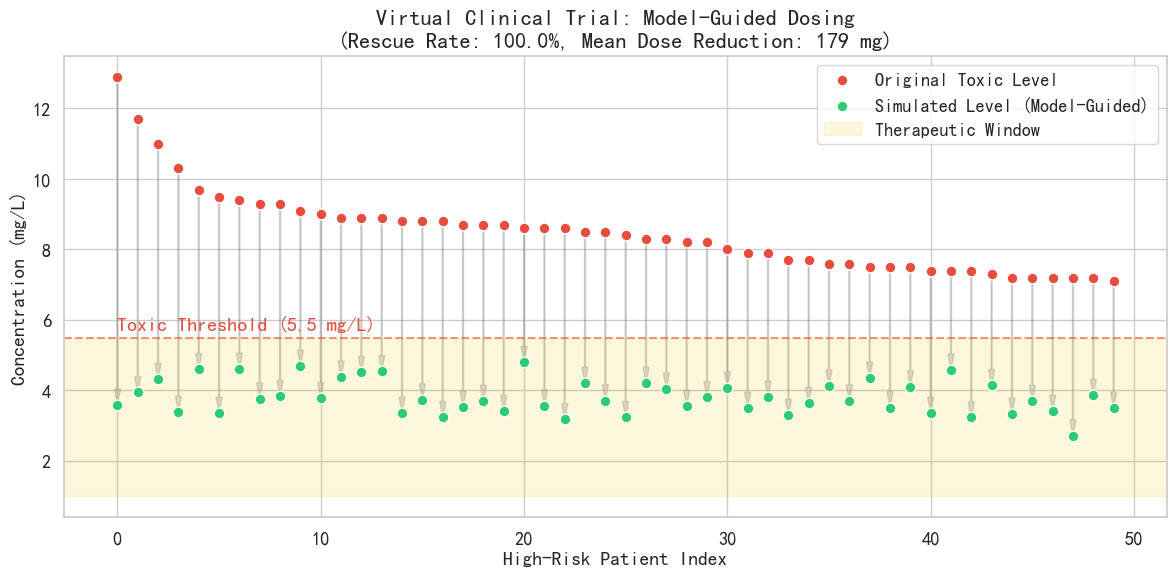

✅ 结果已保存: virtual_trial_results.csv


In [27]:
#虚拟临床试验模拟代码，用于评估混合模型在临床实践中的实用价值
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from xgboost import XGBRegressor
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import PolynomialFeatures
from sklearn.pipeline import make_pipeline

# 设置绘图风格
sns.set_theme(style="whitegrid", font_scale=1.2)
plt.rcParams['font.sans-serif'] = ['SimHei', 'Arial Unicode MS']
plt.rcParams['axes.unicode_minus'] = False

# ==========================================
# 1. 数据准备
# ==========================================
df = pd.read_csv("traindata.csv")
target = 'CL/F'

# 极值处理
features_compact = ['CRP', 'ALB', 'GenotypingValue', 'Age', 'Sex','TBIL', 'Weight']
for col in features_compact:
    if col != 'GenotypingValue' and col in df.columns:
        lower = df[col].quantile(0.01)
        upper = df[col].quantile(0.99)
        df[col] = df[col].clip(lower=lower, upper=upper)

# 划分训练集 (用于训练模型和校准器)
train_idx, test_idx = train_test_split(df.index, test_size=0.2, random_state=42)

# ==========================================
# 2. 训练 Compact Model (预测 CL/F)
# ==========================================
print(">>> [Step 1] 正在训练 Compact Hybrid Model (Target: CL/F)...")
X_train = df.loc[train_idx, features_compact]
y_train = df.loc[train_idx, target]

model = XGBRegressor(n_estimators=1200,learning_rate=0.03,max_depth=5,min_child_weight=5,gamma=0.05,subsample=0.8,
                        colsample_bytree=0.9,reg_alpha=0.1,reg_lambda=1.0)
model.fit(X_train, y_train)

# ==========================================
# 3. 训练非线性校准器 (关键缺失步骤!)
# ==========================================
print(">>> [Step 2] 正在训练非线性校准器 (Calibrator)...")

# 3.1 预测训练集的 CL
pred_cl_train = model.predict(X_train)
pred_cl_train = np.maximum(pred_cl_train, 0.1)

# 3.2 计算理论平均浓度 (Daydose / 24*CL)
train_dose = df.loc[train_idx, 'Daydose']
raw_conc_train = train_dose / (24 * pred_cl_train)

# 3.3 筛选谷浓度样本训练校准器 (Time >= 7d)
train_time = df.loc[train_idx, 'TIME']
train_dv = df.loc[train_idx, 'DV']
mask = train_time >= 7

if mask.sum() > 10:
    X_cal = raw_conc_train[mask].values.reshape(-1, 1)
    y_cal = train_dv[mask].values
else:
    X_cal = raw_conc_train.values.reshape(-1, 1)
    y_cal = train_dv.values

# 3.4 构建并训练 Pipeline (二次多项式 + 线性回归)
calibrator_compact = make_pipeline(PolynomialFeatures(degree=2, include_bias=False), LinearRegression())
calibrator_compact.fit(X_cal, y_cal)

print("    ✅ 校准器训练完成。")

# ==========================================
# 4. 虚拟临床试验 (Virtual Clinical Trial)
# ==========================================
print("\n>>> [Step 3] 开始执行虚拟临床试验...")

# 4.1 筛选高危人群 (真实世界中浓度 > 5.0 mg/L)
toxic_patients = df[df['DV'] > 5.0].copy()
print(f"    纳入高危中毒患者: {len(toxic_patients)} 例")

# 4.2 预测每个患者的 CL/F (使用模型)
toxic_X = toxic_patients[features_compact]
toxic_patients['Predicted_CL'] = model.predict(toxic_X)
toxic_patients['Predicted_CL'] = np.maximum(toxic_patients['Predicted_CL'], 0.1)

# 4.3 计算优化剂量 (Target Cmin = 3.0 mg/L)
# 逻辑：先算当前剂量下的"理论浓度"，再反推需要的剂量比例
# 方法：Proportional Adjustment (更稳健)
# Predicted_Current_DV = Calibrator( Dose / (24*CL) )
raw_conc_toxic = toxic_patients['Daydose'] / (24 * toxic_patients['Predicted_CL'])
pred_dv_toxic = calibrator_compact.predict(raw_conc_toxic.values.reshape(-1, 1))
pred_dv_toxic = np.maximum(pred_dv_toxic, 0.1)

# 计算调整系数
target_conc = 3.0   #治疗窗中部的目标谷浓度
adjustment_ratio = target_conc / pred_dv_toxic  #计算“剂量调整比例”，C目标/C预测=Dose目标/Dose原
# 安全限制：防止剂量变为0 (例如限制最小调整为0.1倍)
adjustment_ratio = np.clip(adjustment_ratio, 0.1, 1.5) 

# 计算新剂量并取整
new_dose_raw = toxic_patients['Daydose'] * adjustment_ratio #Dose目标=比率*原剂量
toxic_patients['Optimized_Dose'] = (new_dose_raw / 50).round() * 50  #四舍五入到 50 mg 给药单位
toxic_patients['Optimized_Dose'] = np.maximum(toxic_patients['Optimized_Dose'], 50) # 设定最小给药剂量50mg

# 4.4 计算虚拟结局 (应用校准器!) 如果这个患者真的按模型建议改剂量，那他的血药浓度会是多少
# -----------------------------------------------------------
# Step A: 计算新剂量下的"理论平均浓度"
# 假设患者 CL 不变 (使用模型预测的 CL)
new_raw_conc = toxic_patients['Optimized_Dose'] / (24 * toxic_patients['Predicted_CL'])

# Step B: 应用校准器得到最终仿真值，每个中毒病人被模型建议调剂量后，模拟得到一个新浓度 Simulated_DV
simulated_vals = calibrator_compact.predict(new_raw_conc.values.reshape(-1, 1))
toxic_patients['Simulated_DV'] = np.maximum(simulated_vals, 0.1)

# 4.5 统计结果
success_rate = (toxic_patients['Simulated_DV'] <= 5.5).mean()
mean_reduction = toxic_patients['Daydose'].mean() - toxic_patients['Optimized_Dose'].mean()
#救援率：有多少患者被拉回“安全窗”
print(f"    救援率 (Rescue Rate): {success_rate:.1%} (目标 < 5.5 mg/L)")
print(f"    平均剂量减少: {mean_reduction:.1f} mg")

# ==========================================
# 5. 可视化 (瀑布图)
# ==========================================
plt.figure(figsize=(12, 6))

# 排序以便绘图
plot_data = toxic_patients.sort_values('DV', ascending=False).reset_index(drop=True)
plot_subset = plot_data.head(50) # 只画前50个避免拥挤

# 绘制点
plt.scatter(plot_subset.index, plot_subset['DV'], color='#e74c3c', label='Original Toxic Level', zorder=3, s=60, edgecolors='w')
plt.scatter(plot_subset.index, plot_subset['Simulated_DV'], color='#2ecc71', label='Simulated Level (Model-Guided)', zorder=3, s=60, edgecolors='w')

# 绘制连线
for i in range(len(plot_subset)):
    plt.arrow(i, plot_subset.loc[i, 'DV'], 
              0, plot_subset.loc[i, 'Simulated_DV'] - plot_subset.loc[i, 'DV'], 
              color='gray', alpha=0.3, width=0.05, head_width=0.3, length_includes_head=True)

# 绘制区域
plt.axhspan(1.0, 5.5, color='#f1c40f', alpha=0.15, label='Therapeutic Window')
plt.axhline(5.5, color='#e74c3c', linestyle='--', alpha=0.6)
plt.text(0, 5.7, 'Toxic Threshold (5.5 mg/L)', color='#e74c3c', fontweight='bold')

plt.ylabel('Concentration (mg/L)', fontsize=14)
plt.xlabel('High-Risk Patient Index', fontsize=14)
plt.title(f'Virtual Clinical Trial: Model-Guided Dosing\n(Rescue Rate: {success_rate:.1%}, Mean Dose Reduction: {mean_reduction:.0f} mg)', fontsize=16, fontweight='bold')
plt.legend(loc='upper right')

plt.tight_layout()
plt.rcParams['font.family'] = 'Arial'
plt.savefig('clinical_utility_simulation.png', dpi=1200)
plt.show()

# 导出数据
toxic_patients[['Daydose', 'Optimized_Dose', 'DV', 'Simulated_DV', 'Predicted_CL']].to_csv('virtual_trial_results.csv', index=False)
print("✅ 结果已保存: virtual_trial_results.csv")

>>> 开始执行外部验证 (External Validation)...
    训练集: C:\Users\28782\Desktop\voriconazole_data有基本信息版.csv
    验证集: C:\Users\28782\Desktop\外部验证.csv
    训练样本量: 546
    外部验证样本量: 166

>>> 正在使用全量训练集重新训练模型...
    ✅ Compact Model (CL/F) 训练完成。
    ✅ 非线性校准器训练完成。

>>> 正在对外部验证集进行预测...

>>> 外部验证结果评估:
    [CL/F] External Validation
    [CL/F] R² = 0.7649
    MAE  = 0.4428 L/h
    MSE  = 0.4245
    RMSE = 0.6515 L/h
    [Concentration] External Validation (Trough Samples n=86)
    R²   = 0.6609
    MAE  = 0.4732 mg/L
    MSE  = 0.4237
    RMSE = 0.6509 mg/L


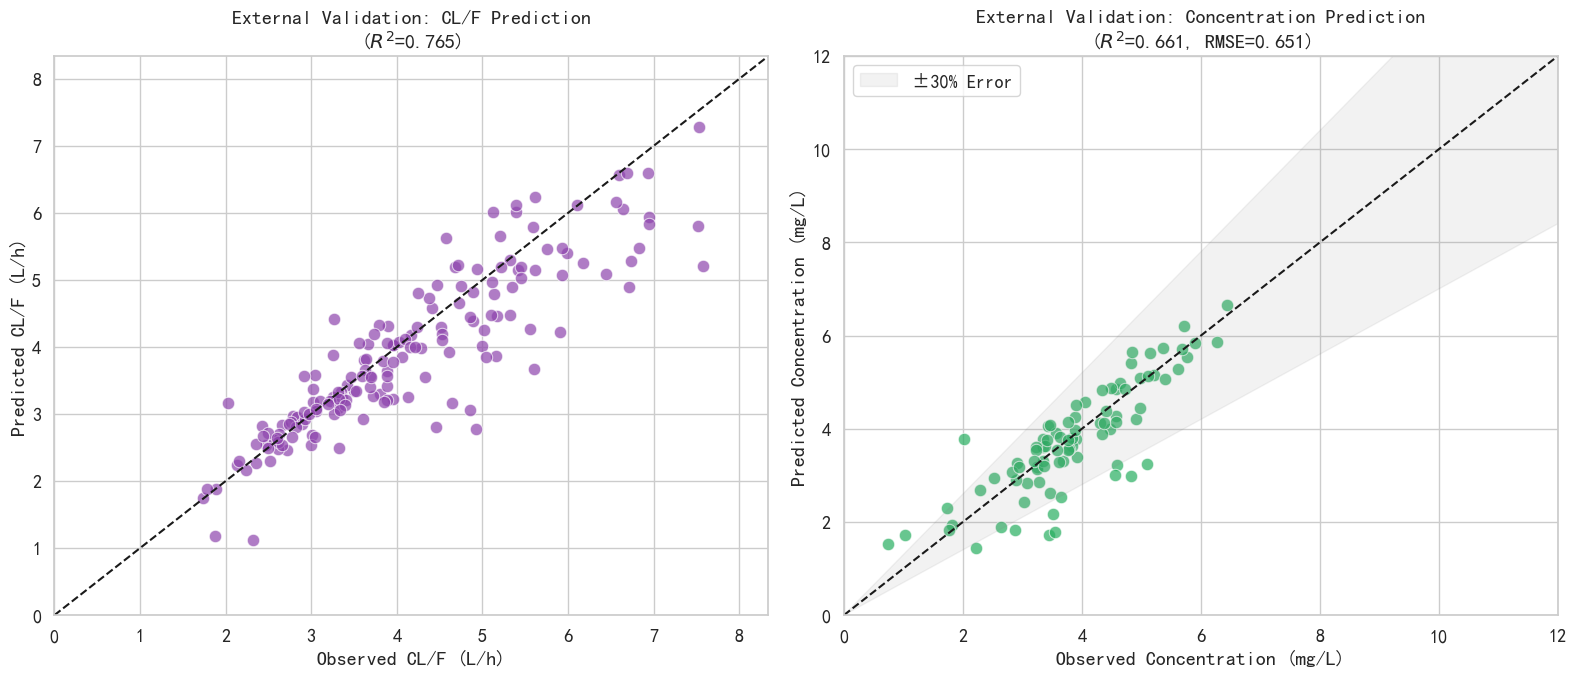


✅ 外部验证图表已保存: External_Validation_Result.png
✅ 预测结果已导出: external_validation_predictions.csv


In [19]:
#外部验证，用于评估模型在新数据集上的泛化能力
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error
from xgboost import XGBRegressor

from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import PolynomialFeatures
from sklearn.pipeline import make_pipeline

# 设置绘图风格
sns.set_theme(style="whitegrid", font_scale=1.2)
plt.rcParams['font.sans-serif'] = ['SimHei', 'Arial Unicode MS']
plt.rcParams['axes.unicode_minus'] = False

# ==========================================
# 1. 配置与数据加载
# ==========================================
TRAIN_FILE = "C:\\Users\\28782\\Desktop\\voriconazole_data有基本信息版.csv" # 原始训练数据
TEST_FILE = "C:\\Users\\28782\\Desktop\\外部验证.csv"            # 外部验证数据

print(f">>> 开始执行外部验证 (External Validation)...")
print(f"    训练集: {TRAIN_FILE}")
print(f"    验证集: {TEST_FILE}")

try:
    df_train = pd.read_csv(TRAIN_FILE)
    df_ext = pd.read_csv(TEST_FILE)
except FileNotFoundError:
    # 尝试 data 目录
    df_train = pd.read_csv(f'data/{TRAIN_FILE}')
    df_ext = pd.read_csv(f'data/{TEST_FILE}')

print(f"    训练样本量: {len(df_train)}")
print(f"    外部验证样本量: {len(df_ext)}")

# ==========================================
# 2. 数据预处理 (保持一致性)
# ==========================================
# 定义核心特征 (Golden 8)
features = ['CRP', 'ALB', 'GenotypingValue', 'Age', 'TBIL', 'Weight','Sex', 'Daydose']
target_cl = 'CL/F'
target_dv = 'DV'

# 极值处理 (Winsorization)
# 注意：在实际应用中，应记录训练集的上下界应用于测试集，或使用临床合理范围
# 这里为了简便，对两组数据分别进行清洗，去除明显的录入错误
def clean_data(df, cols):
    df_clean = df.copy()
    for col in cols:
        if col in df_clean.columns and col != 'GenotypingValue':
            # 使用较宽松的缩尾 (1%-99%) 去除极端异常值
            lower = df_clean[col].quantile(0.01)
            upper = df_clean[col].quantile(0.99)
            df_clean[col] = df_clean[col].clip(lower=lower, upper=upper)
    return df_clean

df_train = clean_data(df_train, features)
df_ext = clean_data(df_ext, features)

# ==========================================
# 3. 训练全量模型 (Retrain on Full Train Data)
# ==========================================
print("\n>>> 正在使用全量训练集重新训练模型...")

# 3.1 训练 XGBoost (预测 CL/F)
X_train = df_train[features]
y_train = df_train[target_cl]

model = XGBRegressor(n_estimators=1200,learning_rate=0.03,max_depth=5,min_child_weight=5,gamma=0.05,subsample=0.8,
                        colsample_bytree=0.9,reg_alpha=0.1,reg_lambda=1.0)

model.fit(X_train, y_train)
print("    ✅ Compact Model (CL/F) 训练完成。")

# 3.2 训练非线性校准器 (Calibrator)
# 计算训练集的理论平均浓度
pred_cl_train = model.predict(X_train)
pred_cl_train = np.maximum(pred_cl_train, 0.1)
train_dose = df_train['Daydose']
# Conc_theory = Dose / (24 * CL)
conc_theory_train = train_dose / (24 * pred_cl_train)

# 筛选谷浓度样本 (Time >= 6d)
train_mask = df_train['TIME'] >= 7
X_cal = conc_theory_train[train_mask].values.reshape(-1, 1)
y_cal = df_train.loc[train_mask, 'DV'].values

# 训练二次多项式校准器
calibrator = make_pipeline(PolynomialFeatures(degree=2, include_bias=False), LinearRegression())
calibrator.fit(X_cal, y_cal)
print("    ✅ 非线性校准器训练完成。")

# ==========================================
# 4. 在外部验证集上进行预测
# ==========================================
print("\n>>> 正在对外部验证集进行预测...")

# 4.1 预测清除率 (CL/F)
X_ext = df_ext[features]
# 预测
ext_pred_cl = model.predict(X_ext)
ext_pred_cl = np.maximum(ext_pred_cl, 0.1) # 物理约束

# 4.2 反推并校准浓度 (Concentration)
# Step A: 理论浓度
ext_dose = df_ext['Daydose']
ext_conc_theory = ext_dose / (24 * ext_pred_cl)

# Step B: 应用校准器
ext_pred_dv = calibrator.predict(ext_conc_theory.values.reshape(-1, 1))
ext_pred_dv = np.maximum(ext_pred_dv, 0.1) # 物理约束

# ==========================================
# 5. 评估与可视化 (Evaluation)
# ==========================================
print("\n>>> 外部验证结果评估:")

# 5.1 清除率评估 (CL/F)
# 检查外部数据是否有 CL/F 列 (通常验证集也有 PK 参数)
if target_cl in df_ext.columns:
    y_true_cl = df_ext[target_cl]
    y_pred_cl = ext_pred_cl
    
    r2_cl = r2_score(df_ext[target_cl], ext_pred_cl)
    mae_cl = mean_absolute_error(y_true_cl, y_pred_cl)
    mse_cl = mean_squared_error(y_true_cl, y_pred_cl)
    rmse_cl = np.sqrt(mean_squared_error(df_ext[target_cl], ext_pred_cl))
    print(f"    [CL/F] External Validation")
    print(f"    [CL/F] R² = {r2_cl:.4f}")
    print(f"    MAE  = {mae_cl:.4f} L/h")
    print(f"    MSE  = {mse_cl:.4f}")
    print(f"    RMSE = {rmse_cl:.4f} L/h")
else:
    print("    [CL/F] 外部数据无真实 CL/F 值，跳过评估。")

# 5.2 浓度评估 (Concentration) - 仅评估谷浓度
# 筛选 Time >= 6h 的样本
ext_mask = df_ext['TIME'] >= 7
if ext_mask.sum() > 0:
    y_true_dv = df_ext.loc[ext_mask, target_dv]
    y_pred_dv = ext_pred_dv[ext_mask]
    
    r2_dv   = r2_score(y_true_dv, y_pred_dv)
    mae_dv  = mean_absolute_error(y_true_dv, y_pred_dv)
    mse_dv  = mean_squared_error(y_true_dv, y_pred_dv)
    rmse_dv = np.sqrt(mse_dv)

    print(f"    [Concentration] External Validation (Trough Samples n={len(y_true_dv)})")
    print(f"    R²   = {r2_dv:.4f}")
    print(f"    MAE  = {mae_dv:.4f} mg/L")
    print(f"    MSE  = {mse_dv:.4f}")
    print(f"    RMSE = {rmse_dv:.4f} mg/L")
else:
    print("    [Concentration] 外部数据没有符合条件的谷浓度样本。")
    y_true_dv = None

# ==========================================
# 6. 绘图 (Figure 6: External Validation)
# ==========================================
fig, axes = plt.subplots(1, 2, figsize=(16, 7))

# Plot A: CL/F 预测
if target_cl in df_ext.columns:
    sns.scatterplot(x=df_ext[target_cl], y=ext_pred_cl, color='#8e44ad', s=80, alpha=0.7, ax=axes[0])
    limit_cl = max(df_ext[target_cl].max(), ext_pred_cl.max()) * 1.1
    axes[0].plot([0, limit_cl], [0, limit_cl], 'k--', linewidth=1.5)
    axes[0].set_title(f'External Validation: CL/F Prediction\n($R^2$={r2_cl:.3f})', fontweight='bold')
    axes[0].set_xlabel('Observed CL/F (L/h)')
    axes[0].set_ylabel('Predicted CL/F (L/h)')
    axes[0].set_xlim(0, limit_cl)
    axes[0].set_ylim(0, limit_cl)

# Plot B: 浓度预测
if ext_mask.sum() > 0:
    sns.scatterplot(x=y_true_dv, y=y_pred_dv, color='#27ae60', s=80, alpha=0.7, ax=axes[1])
    limit_dv = 12 # 固定范围
    axes[1].plot([0, limit_dv], [0, limit_dv], 'k--', linewidth=1.5)
    
    # 误差带
    x_vals = np.linspace(0, limit_dv, 100)
    axes[1].fill_between(x_vals, x_vals*0.7, x_vals*1.3, color='gray', alpha=0.1, label='±30% Error')
    
    axes[1].set_title(f'External Validation: Concentration Prediction\n($R^2$={r2_dv:.3f}, RMSE={rmse_dv:.3f})', fontweight='bold')
    axes[1].set_xlabel('Observed Concentration (mg/L)')
    axes[1].set_ylabel('Predicted Concentration (mg/L)')
    axes[1].set_xlim(0, limit_dv)
    axes[1].set_ylim(0, limit_dv)
    axes[1].legend()

plt.tight_layout()
plt.savefig('External_Validation_Result.png', dpi=300)
plt.show()

print(f"\n✅ 外部验证图表已保存: External_Validation_Result.png")

# ==========================================
# 7. 导出预测结果
# ==========================================
df_ext['Predicted_CL'] = ext_pred_cl
df_ext['Predicted_Conc'] = ext_pred_dv
df_ext['Error_Conc'] = df_ext['Predicted_Conc'] - df_ext['DV']

df_ext.to_csv('external_validation_predictions.csv', index=False)
print(f"✅ 预测结果已导出: external_validation_predictions.csv")

In [31]:
import joblib
import json

# ========== 1. 导出清除率模型 ==========
joblib.dump(model, "xgb_cl.pkl")

# ========== 2. 导出浓度校准器 ==========
joblib.dump(calibrator_compact, "calibrator_DV.pkl")

print("✅ 模型已成功导出")

✅ 模型已成功导出
